### Import Libs

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from GP_DIP_utils import *
from skimage.io import imsave
from skimage.measure import compare_psnr

In [19]:
## import libs
from __future__ import print_function
import gpytorch
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch.optim
import time
from skimage.measure import compare_psnr
from utils.inpainting_utils import * 
import _pickle as cPickle

from skimage.measure import compare_psnr
from utils.inpainting_utils import * 
import _pickle as cPickle
from models import *

## display images
def np_plot(np_matrix, title, opt = 'RGB'):
    plt.figure(2)
    plt.clf()
    if opt == 'RGB':
        fig = plt.imshow(np_matrix.transpose(1, 2, 0), interpolation = 'nearest')
    elif opt == 'map':
        fig = plt.imshow(np_matrix, interpolation = 'bilinear', cmap = cm.RdYlGn)
    elif opt == 'Grayscale':
        plt.gray()
        fig = plt.imshow(np.squeeze(np_matrix.transpose(1, 2, 0)),interpolation = 'none', cmap=plt.get_cmap('gray'))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.axis('off')
    plt.pause(0.05) 

## Load data

### Option \#1: Load images from benchmarks

<Figure size 432x288 with 0 Axes>

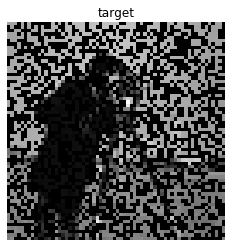

(1, 64, 64)


In [2]:
imlist = ['barbara', 'Cameraman256', 'fingerprint', 'house', 'man', 'peppers256', 'boat', 'couple', 'hill', 'Lena512', 'montage']
im_name = imlist[1] + '.png'
img_path = 'data/inpainting/Dataset_Bernoulli/' + im_name
imsize = 64
dim_div_by = 64

img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_bernoulli_mask(img_pil, zero_fraction=0.5)

img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)
img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)


nsize_H, nsize_W = img_np.shape[1], img_np.shape[2]
plt.figure(4)
np_plot(img_np * img_mask_np, 'target', opt = 'Grayscale')

print(img_np.shape)

### Option \#2  The following mask is used in our experiments

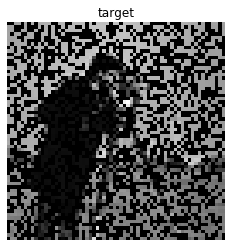

(1, 64, 64)


In [20]:
img_np, img_mask_np, train_x, train_y, test_x = load_test_data_inpainting() 
np_plot(img_np * img_mask_np, 'target', opt = 'Grayscale')
print(img_np.shape)

### Set up GP models

In [21]:
# train_x is the coordinates of the known points while train_y is the RGB of the known points, point each channel seperately
# TODO: get the coordinates of the points

known_parts = np.where(np.squeeze(img_mask_np) == 1)
train_x = np.vstack(known_parts).T
train_y_RGB = np.array([img_np[:, xx[0], xx[1]] for xx in train_x])

miss_parts = np.where(np.squeeze(img_mask_np) == 0)
test_x = np.vstack(miss_parts).T

print(train_x.shape, train_y_RGB.shape, test_x.shape)

train_x = torch.from_numpy(train_x)
train_y_RGB = torch.from_numpy(train_y_RGB) # Channel-wise regression
test_x = torch.from_numpy(test_x)

train_x = train_x.type(torch.FloatTensor)
train_y_RGB = train_y_RGB.type(torch.FloatTensor)
test_x = test_x.type(torch.FloatTensor)


(2066, 2) (2066, 1) (2030, 2)


In [22]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### For grayscale images

In [58]:
# initialize model
train_y = train_y_RGB[:, 0]
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 300
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.log_lengthscale.item(),
        # model.covar_module.log_lengthscale.item(),
        model.likelihood.log_noise.item()
    ))
    optimizer.step()

Iter 1/300 - Loss: 1.135   log_lengthscale: -0.367   log_noise: -0.367
Iter 2/300 - Loss: 1.072   log_lengthscale: -0.295   log_noise: -0.439
Iter 3/300 - Loss: 1.014   log_lengthscale: -0.226   log_noise: -0.514
Iter 4/300 - Loss: 0.956   log_lengthscale: -0.158   log_noise: -0.590
Iter 5/300 - Loss: 0.905   log_lengthscale: -0.092   log_noise: -0.668
Iter 6/300 - Loss: 0.852   log_lengthscale: -0.027   log_noise: -0.748
Iter 7/300 - Loss: 0.811   log_lengthscale: 0.036   log_noise: -0.829
Iter 8/300 - Loss: 0.762   log_lengthscale: 0.097   log_noise: -0.912
Iter 9/300 - Loss: 0.716   log_lengthscale: 0.157   log_noise: -0.997
Iter 10/300 - Loss: 0.663   log_lengthscale: 0.215   log_noise: -1.084
Iter 11/300 - Loss: 0.612   log_lengthscale: 0.273   log_noise: -1.172
Iter 12/300 - Loss: 0.564   log_lengthscale: 0.328   log_noise: -1.261
Iter 13/300 - Loss: 0.511   log_lengthscale: 0.382   log_noise: -1.353
Iter 14/300 - Loss: 0.453   log_lengthscale: 0.434   log_noise: -1.445
Iter 15/3

Iter 115/300 - Loss: -0.815   log_lengthscale: 0.669   log_noise: -5.416
Iter 116/300 - Loss: -0.820   log_lengthscale: 0.671   log_noise: -5.418
Iter 117/300 - Loss: -0.816   log_lengthscale: 0.674   log_noise: -5.419
Iter 118/300 - Loss: -0.818   log_lengthscale: 0.675   log_noise: -5.420
Iter 119/300 - Loss: -0.817   log_lengthscale: 0.676   log_noise: -5.420
Iter 120/300 - Loss: -0.824   log_lengthscale: 0.677   log_noise: -5.420
Iter 121/300 - Loss: -0.804   log_lengthscale: 0.676   log_noise: -5.419
Iter 122/300 - Loss: -0.825   log_lengthscale: 0.675   log_noise: -5.418
Iter 123/300 - Loss: -0.820   log_lengthscale: 0.674   log_noise: -5.417
Iter 124/300 - Loss: -0.816   log_lengthscale: 0.672   log_noise: -5.416
Iter 125/300 - Loss: -0.824   log_lengthscale: 0.671   log_noise: -5.414
Iter 126/300 - Loss: -0.827   log_lengthscale: 0.669   log_noise: -5.413
Iter 127/300 - Loss: -0.821   log_lengthscale: 0.667   log_noise: -5.411
Iter 128/300 - Loss: -0.822   log_lengthscale: 0.66

Iter 228/300 - Loss: -0.815   log_lengthscale: 0.662   log_noise: -5.406
Iter 229/300 - Loss: -0.815   log_lengthscale: 0.662   log_noise: -5.407
Iter 230/300 - Loss: -0.814   log_lengthscale: 0.662   log_noise: -5.408
Iter 231/300 - Loss: -0.822   log_lengthscale: 0.663   log_noise: -5.408
Iter 232/300 - Loss: -0.815   log_lengthscale: 0.665   log_noise: -5.409
Iter 233/300 - Loss: -0.825   log_lengthscale: 0.667   log_noise: -5.409
Iter 234/300 - Loss: -0.809   log_lengthscale: 0.668   log_noise: -5.410
Iter 235/300 - Loss: -0.818   log_lengthscale: 0.668   log_noise: -5.410
Iter 236/300 - Loss: -0.817   log_lengthscale: 0.669   log_noise: -5.410
Iter 237/300 - Loss: -0.817   log_lengthscale: 0.669   log_noise: -5.410
Iter 238/300 - Loss: -0.820   log_lengthscale: 0.669   log_noise: -5.409
Iter 239/300 - Loss: -0.810   log_lengthscale: 0.669   log_noise: -5.409
Iter 240/300 - Loss: -0.829   log_lengthscale: 0.669   log_noise: -5.408
Iter 241/300 - Loss: -0.820   log_lengthscale: 0.66

## Inpainting by regression

In [59]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
test_y = model(test_x)
train_y_pred = model(train_x)

## Experimental results

In [60]:
train_x_np = train_x.data.numpy()
train_x_np = train_x_np.astype(int)
test_x_np = test_x.data.numpy()
test_x_np = test_x_np.astype(int)

In [61]:
corrupted_img = img_np * img_mask_np
pred_img = img_np * img_mask_np
pred_y = test_y.mean.data.numpy()
pred_y_var = test_y.variance.data.numpy()
train_y_var = train_y_pred.variance.data.numpy()
uncertainty_map = np.zeros((img_np.shape[1], img_np.shape[1]))
for i, xx in enumerate(test_x_np):
    pred_img[0, xx[0], xx[1]] = pred_y[i]
    uncertainty_map[xx[0], xx[1]] = pred_y_var[i]
for i, xx in enumerate(train_x_np):
    uncertainty_map[xx[0], xx[1]] = train_y_var[i]

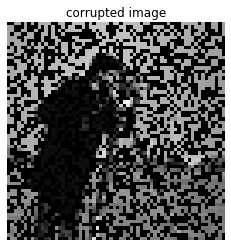

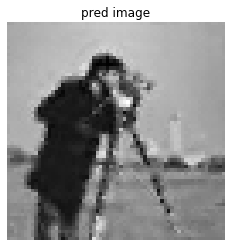

PSNR: 25.78265459757473


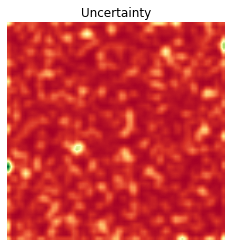

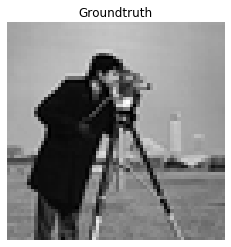

In [62]:
np_plot(corrupted_img, 'corrupted image', opt = 'Grayscale')
np_plot(pred_img, 'pred image', opt = 'Grayscale')
# compare psnr
psnr_gt = compare_psnr(img_np, pred_img)
print('PSNR:', psnr_gt)
np_plot(uncertainty_map, 'Uncertainty', opt = 'map')
np_plot(img_np, 'Groundtruth', opt = 'Grayscale')

## To reproduce the results in our paper, load the trained RBF model

#### Load the mask used in our experiments

In [52]:
img_np, img_mask_np, train_x, train_y, test_x = load_test_data_inpainting()

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
train_x = train_x.type(torch.FloatTensor)
train_y = train_y.type(torch.FloatTensor)
test_x = test_x.type(torch.FloatTensor)

#### Load the trained GP model with RBF kernel

In [53]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
RBF_trained_model = ExactGPModel(train_x, train_y, likelihood)
RBF_trained_model.load_state_dict(torch.load('GP_RBF_inpaint_baseline')) # ./data/models/GP_RBF_inpaint_baseline

#### Inpainting via Gaussian Process regression

In [54]:
# Get into evaluation (predictive posterior) mode
RBF_trained_model.eval()
test_y = RBF_trained_model(test_x)
train_y_pred = RBF_trained_model(train_x)
### print the learned parameters
print('outputscale: %.5f' % RBF_trained_model.covar_module.outputscale)
print('log(lengthscale): %.5f' % RBF_trained_model.covar_module.base_kernel.log_lengthscale)

outputscale: 0.03068
log(lengthscale): 0.67132


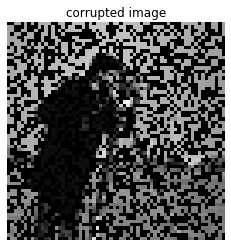

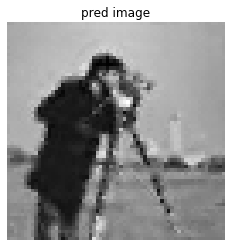

PSNR: 25.78265459757473


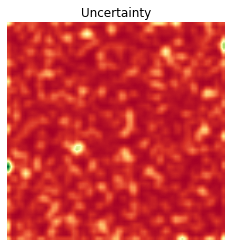

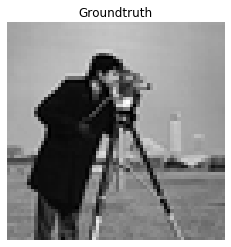

In [55]:
train_x_np = train_x.data.numpy()
train_x_np = train_x_np.astype(int)
test_x_np = test_x.data.numpy()
test_x_np = test_x_np.astype(int)
corrupted_img = img_np * img_mask_np
pred_img = img_np * img_mask_np
pred_y = test_y.mean.data.numpy()
pred_y_var = test_y.variance.data.numpy()
train_y_var = train_y_pred.variance.data.numpy()
uncertainty_map = np.zeros((img_np.shape[1], img_np.shape[1]))
for i, xx in enumerate(test_x_np):
    pred_img[0, xx[0], xx[1]] = pred_y[i]
    uncertainty_map[xx[0], xx[1]] = pred_y_var[i]
for i, xx in enumerate(train_x_np):
    uncertainty_map[xx[0], xx[1]] = train_y_var[i]
    
np_plot(corrupted_img, 'corrupted image', opt = 'Grayscale')
np_plot(pred_img, 'pred image', opt = 'Grayscale')
# compare psnr
psnr_gt = compare_psnr(img_np, pred_img)
print('PSNR:', psnr_gt)
np_plot(uncertainty_map, 'Uncertainty', opt = 'map')
np_plot(img_np, 'Groundtruth', opt = 'Grayscale')